# Persistence Baseline Evaluation

## Imports & paths

In [45]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [46]:
ROOT = Path.cwd().parent  # adjust if notebook opened from project root
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_PATH = ROOT / "results" / "baseline_persistence_metrics.json"

## Load processed data & inspect

In [47]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
print(df.shape)
df.head()

(17520, 38)


,timestamp,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,month_sin,month_cos,dayofyear_sin,dayofyear_cos,lag_1,lag_3,lag_6,lag_24,rolling_3,rolling_24
0,2011-01-02 00:00:00,25.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.5,0.866025,0.034328,0.999411,39.0,34.0,35.0,16.0,28.000000,41.083333
1,2011-01-02 01:00:00,26.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,0.5,0.866025,0.034328,0.999411,17.0,28.0,37.0,40.0,24.333333,40.125000
2,2011-01-02 02:00:00,27.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,...,0.5,0.866025,0.034328,0.999411,17.0,39.0,36.0,32.0,14.333333,39.166667
3,2011-01-02 03:00:00,28.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,...,0.5,0.866025,0.034328,0.999411,9.0,17.0,34.0,13.0,10.666667,38.875000
4,2011-01-02 04:00:00,29.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,...,0.5,0.866025,0.034328,0.999411,6.0,17.0,28.0,1.0,6.000000,38.958333


In [48]:
df["cnt"].describe()

count    17520.000000
mean       187.996119
std        181.383739
min          1.000000
25%         38.000000
50%        140.000000
75%        280.000000
max        977.000000
Name: cnt, dtype: float64

## Persistence predictions


In [49]:
df["prediction"] = df["cnt"].shift(1)
baseline_df = df.dropna().reset_index(drop=True)
TEST_FRACTION = 0.2
split_idx = int(len(baseline_df) * (1 - TEST_FRACTION))
test_df = baseline_df.iloc[split_idx:].reset_index(drop=True)
test_df.shape

(3504, 39)

## Metric helper

In [50]:
def regression_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "mape": mape}

In [51]:
metrics = regression_metrics(test_df["cnt"], test_df["prediction"])
metrics

{'rmse': 128.7905198463113,
 'mae': 84.08932648401826,
 'mape': 0.5399030670035341}

In [52]:
RESULTS_PATH.parent.mkdir(exist_ok=True)
with RESULTS_PATH.open("w") as f:
    json.dump({k: float(v) for k, v in metrics.items()}, f, indent=2)
print(f"Saved metrics to {RESULTS_PATH}")

Saved metrics to C:\Users\ericb\source\bike_forecast\results\baseline_persistence_metrics.json


## Visualization

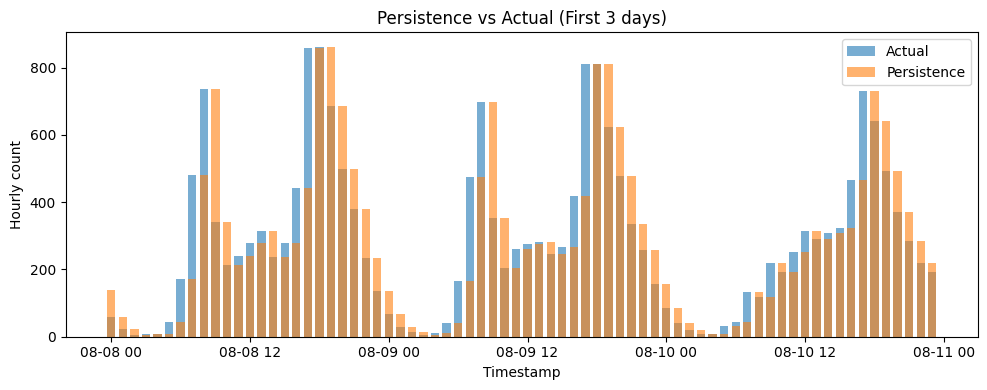

In [53]:
window = test_df.iloc[:72]  # 3 days
plt.figure(figsize=(10, 4))
plt.bar(window["timestamp"], window["cnt"], width=0.03, label="Actual", alpha=0.6)
plt.bar(window["timestamp"], window["prediction"], width=0.03, label="Persistence", alpha=0.6)
plt.title("Persistence vs Actual (First 3 days)")
plt.xlabel("Timestamp")
plt.ylabel("Hourly count")
plt.legend()
plt.tight_layout()

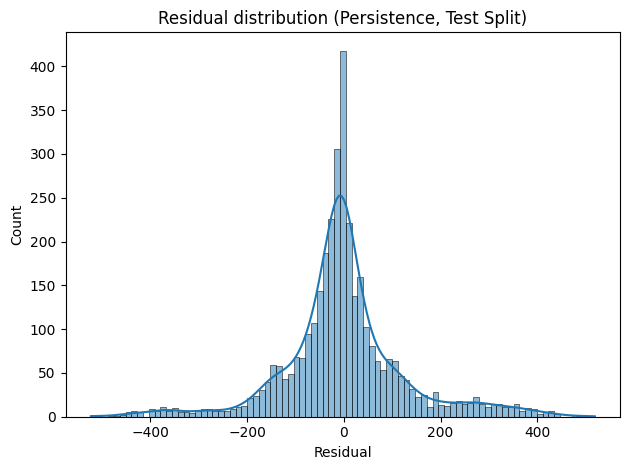

In [54]:
sns.histplot(test_df["cnt"] - test_df["prediction"], kde=True)
plt.title("Residual distribution (Persistence, Test Split)")
plt.xlabel("Residual")
plt.tight_layout()

## Summary

In [55]:
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']*100:.2f}%")
print("These persistence metrics form the benchmark each new model must surpass to demonstrate meaningful improvement in predictive accuracy.")

RMSE: 128.79
MAE: 84.09
MAPE: 53.99%
These persistence metrics form the benchmark each new model must surpass to demonstrate meaningful improvement in predictive accuracy.
